In [7]:
import torch
import triton
import triton.language as tl
from triton.runtime import driver
from pprint import pprint, pformat
import torch.nn.functional as F

In [3]:
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')
properties = driver.active.utils.get_device_properties(DEVICE.index)
pprint(f"{properties=}", underscore_numbers=True)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

("properties={'max_shared_mem': 101376, 'max_num_regs': 65536, "
 "'multiprocessor_count': 64, 'warpSize': 32, 'sm_clock_rate': 1695000, "
 "'mem_clock_rate': 8001000, 'mem_bus_width': 384}")


In [68]:
# @triton.autotune(
#     configs=[
#         triton.Config({"BLOCK_SIZE": 64}, num_stages=2),
#         # triton.Config({"BLOCK_SIZE": 128}, num_stages=3),
#     ],
#     key=["num_rows", "num_cols"],
# )
@triton.jit
def layernorm_kernel(input_ptr: torch.Tensor, output_ptr: torch.Tensor, 
                     gamma: torch.Tensor, beta: torch.Tensor, 
                     input_row_stride: int,
                     num_rows: int, num_cols: int, 
                     eps: float,
                     BLOCK_SIZE: tl.constexpr, num_stages: tl.constexpr):
    row_idx = tl.program_id(0)
    
    sum_x = 0.0
    sum_squared_x = 0.0
    row_start_ptr = input_ptr + row_idx * input_row_stride
    output_row_start_ptr = output_ptr + row_idx * input_row_stride
    col_offsets = tl.arange(0, BLOCK_SIZE)
    for col in tl.range(0, num_cols, BLOCK_SIZE, num_stages=num_stages):
        row_ptrs = row_start_ptr + col_offsets + col
        mask = (col_offsets + col) < num_cols
        x = tl.load(row_ptrs, mask=mask, other=0.0)
        sum_x += tl.sum(x)
        sum_squared_x += tl.sum(x * x)
    
    mean = sum_x / num_cols
    var = (sum_squared_x / num_cols) - (mean * mean)
    inv_std = tl.rsqrt(var + eps)
    
    for col in tl.range(0, num_cols, BLOCK_SIZE, num_stages=num_stages):
        row_ptrs = row_start_ptr + col_offsets + col
        mask = (col_offsets + col) < num_cols
        input_block = tl.load(row_ptrs, mask=mask, other=0.0)
        gammas = tl.load(gamma + col_offsets + col, mask=mask, other=1.0)
        betas = tl.load(beta + col_offsets + col, mask=mask, other=0.0)
        norm = (input_block - mean) * inv_std
        output = norm * gammas + betas
        tl.store(output_row_start_ptr + col_offsets + col, output, mask=mask)

        
        

In [84]:
def layernorm(a: torch.Tensor, gamma: torch.Tensor, beta: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    b = torch.zeros_like(a)
    M, N = a.shape
    num_stages = 8
    BLOCK_SIZE = 1024
    grid= (M,)
    layernorm_kernel[grid](a, b, gamma, beta,a.stride(0), M, N, eps, BLOCK_SIZE=BLOCK_SIZE, num_stages=num_stages)
    return b

In [85]:
torch.manual_seed(0)
a = torch.randn((64, 512), device=DEVICE, dtype=torch.float32)
N, D = a.shape
gamma = torch.randn(512, device=DEVICE, dtype=torch.float32)
beta = torch.randn(512, device=DEVICE, dtype=torch.float32)
triton_output = layernorm(a, gamma, beta, eps=1e-5)
torch_output = F.layer_norm(a, normalized_shape=(D,), weight=gamma, bias=beta, eps=1e-5)
if torch.allclose(triton_output, torch_output, atol=0.125, rtol=0):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

✅ Triton and Torch match


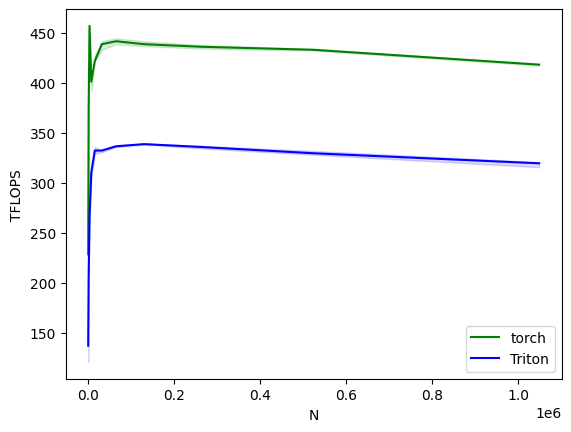

matmul-performance-fp32:
            N       torch      Triton
0      1024.0  228.444436  137.066670
1      2048.0  373.818179  205.600005
2      4096.0  456.888873  265.290326
3      8192.0  401.170738  310.339624
4     16384.0  421.743604  332.282838
5     32768.0  438.613313  332.282838
6     65536.0  441.557048  336.531962
7    131072.0  438.613313  338.697564
8    262144.0  436.069596  335.887671
9    524288.0  433.020177  329.577948
10  1048576.0  418.183351  319.524050
None


In [86]:
configs = []
ref_lib = "torch"
batch_sizes = [256]
for M in batch_sizes:
    configs.append(
        triton.testing.Benchmark(
            x_names=["N"],  # Argument names to use as an x-axis for the plot
            x_vals=[2**i for i in range(10, 21)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=[ref_lib.lower(), "triton"] , # Label name for the lines
            line_names=[ref_lib, "Triton"],  # Line styles
            styles=[("green", "-"), ("blue", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-" +
            ("fp32"),  # Name for the plot, used also as a file name for saving the plot.
            args={"M": M},
        ))
@triton.testing.perf_report(configs)
def benchmark(N, provider, M):
    a = torch.randn((M, N), device=DEVICE, dtype=torch.float32)
    gamma = torch.randn(N, device=DEVICE, dtype=torch.float32)
    beta = torch.randn(N, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: F.layer_norm(a, normalized_shape=(N,), weight=gamma, bias=beta, eps=1e-5), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: layernorm(a, gamma, beta, eps=1e-5), quantiles=quantiles)
    # Calculate memory bandwidth: bytes_accessed / runtime_in_seconds
    # For LayerNorm, we read the input tensor once, read gamma and beta, and write to output
    # Each float32 element is 4 bytes
    bytes_accessed = M * N * 4 * 2 + N * 4 * 2  # Input + Output + gamma + beta
    gb_per_s = lambda ms: bytes_accessed * 1e-9 / (ms * 1e-3)
    
    return gb_per_s(ms), gb_per_s(max_ms), gb_per_s(min_ms)


print(benchmark.run(show_plots=True, print_data=True))